### Import Libraries

Import necessary libraries

In [1]:
import glob
import os
import librosa
import librosa.display
import time
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import skimage.io
import re
from IPython.display import display, Image
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Input, Dense, Flatten
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16
# from tensorflow.keras.applications.vgg19 import VGG19 as VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
import tensorflow as tf

# !pip install keras_cv
# import keras_cv

# !pip install cutmix-keras
# from cutmix_keras import CutMixImageDataGenerator

In [2]:
# input_dir = '../input/audio-features/mel_trim_216x216'
# input_dir = '../input/audio-features/mel_trim_4x4'
# input_dir = '../input/audio-features/new'

In [3]:
BATCH = 32

In [4]:
def get_sets(folder):
    images = []
    labels = []
    for dirname, _, files in os.walk(folder):
        for file in files:
            file_path = os.path.join(dirname, file)
            images.append(file_path)
            labels.append(file.split('_')[0])
    di = {
    'image': images,
    'label': labels
    }
    return pd.DataFrame(di)
        

In [5]:
# train = get_sets('../input/audio-features-2/new/train')
# val = get_sets('../input/audio-features-2/new/val')
# test = get_sets('../input/audio-features-2/new/test')

train = get_sets('../input/audio-features/new/new/train')
val = get_sets('../input/audio-features/new/new/val')
test = get_sets('../input/audio-features/new/new/test')

In [6]:
train.shape, val.shape, test.shape

((10672, 2), (2668, 2), (2669, 2))

In [7]:
train.head()

,image,label
0,../input/audio-features/new/new/train/angry_93...,angry
1,../input/audio-features/new/new/train/fear_987...,fear
2,../input/audio-features/new/new/train/fear_493...,fear
3,../input/audio-features/new/new/train/sad_3830...,sad
4,../input/audio-features/new/new/train/happy_32...,happy


In [8]:
np.unique(train['label'])

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad'],
      dtype=object)

Text(0.5, 1.0, 'emotion: disgust')

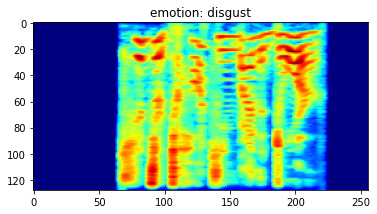

In [9]:
import random

index = random.randint(0, 2800)

plt.imshow(plt.imread(train['image'][index]))
plt.title('emotion: ' + train['label'][index])

In [10]:
train['label'].value_counts()

happy      1806
angry      1792
sad        1782
fear       1776
disgust    1770
neutral    1746
Name: label, dtype: int64

In [11]:
val['label'].value_counts()

happy      451
angry      447
sad        446
fear       444
disgust    443
neutral    437
Name: label, dtype: int64

In [12]:
test['label'].value_counts()

happy      451
angry      448
sad        446
fear       444
disgust    443
neutral    437
Name: label, dtype: int64

256 128


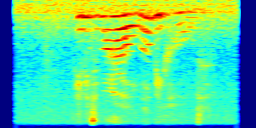

In [13]:
import PIL

image = PIL.Image.open(train['image'][2])

width, height = image.size

print(width, height)
display(image)

In [14]:
from keras.preprocessing.image import ImageDataGenerator

In [15]:
datagen = ImageDataGenerator(rescale=1.0/255.0)
# datagen = ImageDataGenerator(samplewise_center=True)
# datagen = ImageDataGenerator(samplewise_center=True, samplewise_std_normalization=True)

In [16]:
# train_set1 = datagen.flow_from_dataframe(
#     dataframe=train,
#     x_col="image",
#     y_col="label",
#     batch_size=32,
#     shuffle=True,
#     class_mode="categorical",
#     target_size=(width, height))

# train_set2 = datagen.flow_from_dataframe(
#     dataframe=train,
#     x_col="image",
#     y_col="label",
#     batch_size=32,
#     shuffle=True,
#     class_mode="categorical",
#     target_size=(width, height))

# # CutMixImageDataGenerator
# train_set = CutMixImageDataGenerator(
#     generator1=train_set1,
#     generator2=train_set2,
#     img_size=(width, height),
#     batch_size=32,
# )

train_set = datagen.flow_from_dataframe(
    dataframe=train,
    x_col="image",
    y_col="label",
    batch_size=BATCH,
    shuffle=True,
    class_mode="categorical",
    target_size=(width, height))

Found 10672 validated image filenames belonging to 6 classes.


In [17]:
val_set = datagen.flow_from_dataframe(
    dataframe=val,
#     directory="face_mask_detection/train",
    x_col="image",
    y_col="label",
    batch_size=BATCH,
#     shuffle=True,
    class_mode="categorical",
    target_size=(width, height))

Found 2668 validated image filenames belonging to 6 classes.


In [18]:
test_set = datagen.flow_from_dataframe(
    dataframe=test,
#     directory="face_mask_detection/train",
    x_col="image",
    y_col="label",
    batch_size=BATCH,
    shuffle=False,
    class_mode="categorical",
    target_size=(width, height))

Found 2669 validated image filenames belonging to 6 classes.


In [19]:
def evaluationReport(hist, model):
    plt.plot(hist.history['loss'], label='train loss')
    plt.plot(hist.history['val_loss'], label='val loss')
    plt.legend()
    plt.show()
    
    plt.plot(hist.history['accuracy'], label='train accuracy')
    plt.plot(hist.history['val_accuracy'], label='val_accuracy')
    plt.legend()
    plt.show()
    
    labels = np.unique(train['label'])
    
    x, y = zip(*(test_set[i] for i in range(len(test_set))))
    x_test, y_test = np.vstack(x), np.vstack(y)
    
    print('Evaluation on the test set:')
    result = model.evaluate(x_test, y_test, batch_size=32)
    print("Test Loss, Test Acc:", result)
    
    preds = model.predict(test_set)
    
    y_pred = np.argmax(preds, axis=1)
    print()
    print(classification_report(test_set.classes,y_pred))

    print('Confusion Matrix')
    # Confusion Matrix
    cm = confusion_matrix(test_set.classes, y_pred)
    # print(cm)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);
    # labels, title and ticks
    ax.set_xlabel('Predicted labels');
    ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(labels);
    ax.yaxis.set_ticklabels(labels);
    

In [20]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

EPOCH = 30
base_lr = 1e-6
STEP_SIZE_TRAIN = train_set.n//train_set.batch_size
# STEP_SIZE_TRAIN = train_set.get_steps_per_epoch()
STEP_SIZE_VALID = val_set.n//val_set.batch_size
STEP_SIZE_TEST = test_set.n//test_set.batch_size

es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)

mc = ModelCheckpoint('./mode_ckpt', save_best_only=True, save_weights_only=True, verbose=1)

lrs = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.8,
    patience=2,
    cooldown=0,
    verbose=1,
    mode="min",
    min_delta=0.0001,
    min_lr=1e-13
)


lr_exp = tf.keras.optimizers.schedules.ExponentialDecay(
    base_lr,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

In [21]:
import math

def get_lr_callback(mode='exp', batch_size=64, epochs=30, plot=False):
    """adapted from @cdeotte"""
    lr_start = 5e-5
    lr = 0.001 # base_lr
    lr_max = 5e-4 # max lr - will be multiplied by batch_size
    lr_min = 0.1e-4 # min lr
    lr_ramp_ep = 4 # warming up epochs
    lr_sus_ep = 0 # sustain epochs lr after warming up
    lr_decay = 0.8 # decay rate

    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start

        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max

        elif mode == 'exp':
            lr = (lr_max - lr_min) * lr_decay**(epoch - \
                  lr_ramp_ep - lr_sus_ep) + lr_min

        elif mode == 'step':
            lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)

        elif mode == 'cosine':
            decay_total_epochs = epochs - lr_ramp_ep - lr_sus_ep + 3
            decay_epoch_index = epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            cosine_decay = 0.5 * (1 + math.cos(phase))
            lr = (lr_max - lr_min) * cosine_decay + lr_min
        return lr

    if plot:
        plt.figure(figsize=(10, 5))
        plt.plot(
            np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch')
        plt.ylabel('learnig rate')
        plt.title('Learning Rate Scheduler')
    return tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=0)

In [22]:
# lr_v2 = get_lr_callback(mode='cosine',epochs=EPOCH,plot=True,batch_size=BATCH)

In [23]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=base_lr)
callbacks = [
    es,
    lrs
]

# VGG16

In [24]:
image_size = [width, height]
vgg = VGG16(input_shape = image_size + [3], weights = 'imagenet', include_top =  False)
# for layer in vgg.layers:
#     layer.trainable = False
vgg.trainable = True

for layer in vgg.layers[:-5]:
    layer.trainable = False
    
# vgg.trainable = False

x = Flatten()(vgg.output)
prediction = Dense(len(np.unique(train['label'])), activation = 'softmax')(x)

2022-09-24 06:12:48.823197: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-24 06:12:48.919057: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-24 06:12:48.919939: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-24 06:12:48.921833: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step


In [25]:
model = Model(inputs = vgg.input, outputs = prediction)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 128, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 64, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 64, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 64, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 32, 128)       0     

In [26]:
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])

In [27]:
mod = model.fit(
  train_set,
  validation_data=val_set,
  epochs=EPOCH,
  callbacks=callbacks,
  steps_per_epoch=STEP_SIZE_TRAIN,
  validation_steps=STEP_SIZE_VALID,
  use_multiprocessing=True,
  workers=10
)

2022-09-24 06:12:52.513696: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-09-24 06:12:55.155101: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


333/333 [==============================] - 51s 122ms/step - loss: 1.8396 - accuracy: 0.2244 - val_loss: 1.6871 - val_accuracy: 0.3166
Epoch 2/30
333/333 [==============================] - 38s 111ms/step - loss: 1.6051 - accuracy: 0.3692 - val_loss: 1.5296 - val_accuracy: 0.4032
Epoch 3/30
333/333 [==============================] - 39s 115ms/step - loss: 1.4510 - accuracy: 0.4568 - val_loss: 1.3828 - val_accuracy: 0.4785
Epoch 4/30
333/333 [==============================] - 39s 115ms/step - loss: 1.3175 - accuracy: 0.5214 - val_loss: 1.2737 - val_accuracy: 0.5279
Epoch 5/30
333/333 [==============================] - 40s 115ms/step - loss: 1.2208 - accuracy: 0.5564 - val_loss: 1.2064 - val_accuracy: 0.5501
Epoch 6/30
333/333 [==============================] - 39s 113ms/step - loss: 1.1532 - accuracy: 0.5833 - val_loss: 1.1569 - val_accuracy: 0.5670
Epoch 7/30
333/333 [==============================] - 39s 112ms/step - loss: 1.1022 - accuracy: 0.5983 - val_loss: 1.1219 - val_accuracy: 0.5

In [28]:
# from tensorflow.keras.models import load_model
# model.save('./vgg16')

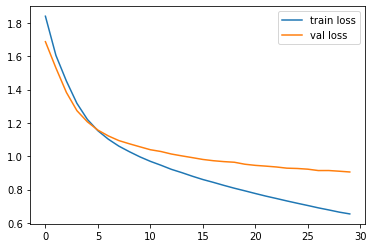

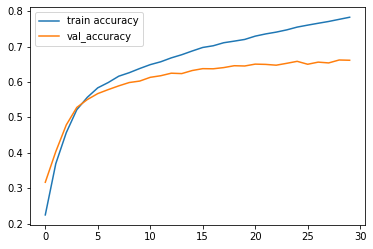

Evaluation on the test set:


2022-09-24 06:33:15.483943: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1049493504 exceeds 10% of free system memory.
2022-09-24 06:33:16.652789: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1049493504 exceeds 10% of free system memory.


84/84 [==============================] - 4s 51ms/step - loss: 0.8921 - accuracy: 0.6695
Test Loss, Test Acc: [0.8921238780021667, 0.6695391535758972]

              precision    recall  f1-score   support

           0       0.76      0.76      0.76       448
           1       0.62      0.63      0.63       443
           2       0.60      0.58      0.59       444
           3       0.65      0.65      0.65       451
           4       0.73      0.74      0.74       437
           5       0.65      0.66      0.66       446

    accuracy                           0.67      2669
   macro avg       0.67      0.67      0.67      2669
weighted avg       0.67      0.67      0.67      2669

Confusion Matrix


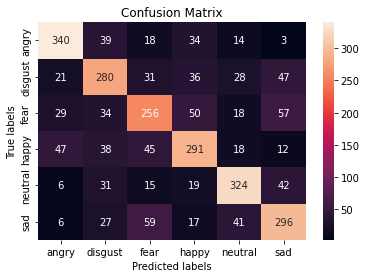

In [29]:
evaluationReport(mod, model)

In [30]:
dfasdfasdf

NameError: name 'dfasdfasdf' is not defined

# Fine-tuning

In [ ]:
vgg.trainable = True

for layer in vgg.layers[:10]:
    layer.trainable = False

In [ ]:
for i, layer in enumerate(vgg.layers):
    print(i, layer, layer.trainable)

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate=base_lr/100), metrics = ['accuracy'])
model.summary()

In [ ]:
mod = model.fit(
  train_set,
  validation_data=val_set,
  epochs=500,
  callbacks=[es_callback, lrs],
  steps_per_epoch=STEP_SIZE_TRAIN,
  validation_steps=STEP_SIZE_VALID,
  use_multiprocessing=True,
  workers=10
)

In [ ]:
evaluationReport(mod, model)